In [1]:
import numpy as np 
import pandas as pd
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Data Processing

In [2]:
cleaned_close = sio.loadmat('../Pcleaned.mat')['P']
cleaned_close_stock_1_raw = cleaned_close[25:, 0]
cleaned_close_stock_1_df = pd.DataFrame({'Close': cleaned_close_stock_1_raw})
macd_raw = pd.read_csv('../macd.csv').dropna()
rsi_raw = pd.read_csv('../rsi.csv').dropna()
momentum_raw = pd.read_csv('../momentum.csv').dropna()
acceleration_raw = pd.read_csv('../acceleration.csv').dropna()[1:]
volatility_raw = pd.read_csv('../volatility.csv').dropna()[7:]
neg_vol_raw = pd.read_csv('../neg_volume.csv').dropna()[25:]
pos_vol_raw = pd.read_csv('../pos_volume.csv').dropna()[25:]
on_bal_vol_raw = pd.read_csv('../on_bal_volume.csv').dropna()[25:]
pvt_raw = pd.read_csv('../pvt.csv').dropna()[25:]
pricechangerate_raw = pd.read_csv('../PriceChangeRate.csv').dropna()[14:]

In [3]:
macd = macd_raw['Close'].values.reshape(-1,1)
rsi = rsi_raw['RelativeStrengthIndex'].values.reshape(-1,1)
momentum = momentum_raw['Close'].values.reshape(-1,1)
acceleration = acceleration_raw['Close'].values.reshape(-1,1)
volatility = volatility_raw['ChaikinVolatility'].values.reshape(-1,1)
neg_vol = neg_vol_raw['NegativeVolume'].values.reshape(-1,1)
pos_vol = pos_vol_raw['PositiveVolume'].values.reshape(-1,1)
on_bal_vol = on_bal_vol_raw['OnBalanceVolume'].values.reshape(-1,1)
pvt = pvt_raw['PriceVolumeTrend'].values.reshape(-1,1)
pricechangerate = pricechangerate_raw['PriceROC'].values.reshape(-1,1)
cleaned_close_stock_1 = cleaned_close_stock_1_raw.reshape(-1,1)

In [4]:
pricechangerate.shape

(1647, 1)

In [5]:
X = np.array([macd, rsi, momentum, acceleration, volatility, neg_vol, pos_vol, on_bal_vol, pvt, pricechangerate])
# X = np.array([macd, rsi, momentum, acceleration, volatility])
# X = np.array([macd,volatility])
# X = np.array([macd, rsi, acceleration, volatility, pricechangerate])
# X = np.array([neg_vol, pos_vol, on_bal_vol, pvt])
X = np.transpose(X[:,:,0])

In [6]:
X[:,0]

array([ 0.2601261 ,  0.1948557 ,  0.1606426 , ...,  0.06523132,
       -0.06212616, -0.2728844 ])

# Train Test Split

In [7]:
train_proportion = 0.9

In [8]:
X_train = X[0:int(train_proportion*X.shape[0]), :]
X_test = X[int(train_proportion*X.shape[0]):, :]

y_train = cleaned_close_stock_1[0:int(train_proportion*X.shape[0])]
y_test = cleaned_close_stock_1[int(train_proportion*X.shape[0]):]

In [9]:
# check correlation among features 
index_cor_pair = {}
for i in range(X_train.shape[1]):
    for j in range(X_train.shape[1]):
        if i != j :
            if (i,j) not in index_cor_pair and (j,i) not in index_cor_pair:
                index_cor_pair[(i,j)] = np.corrcoef(X_train[:,i].reshape(1,-1), X_train[:,j].reshape(1,-1))[0,1]

In [10]:
for w in sorted(index_cor_pair, key=index_cor_pair.get):
    print(w, index_cor_pair[w])

(4, 5) -0.008268679396553017
(1, 5) 0.009648011443729976
(3, 5) 0.017274783280548704
(4, 8) 0.017467845155390144
(5, 9) 0.0188791052020038
(2, 3) 0.019478016427118175
(4, 7) 0.01985082805715596
(1, 3) 0.02877833005515844
(3, 7) 0.03540030606062085
(3, 4) 0.03899230232610354
(3, 6) 0.041758731453681835
(4, 6) 0.04550884319226948
(2, 5) 0.05284032148265357
(3, 8) 0.05527641268008121
(0, 5) 0.06178110265612262
(6, 9) 0.06797804099612567
(4, 9) 0.08418753910869123
(1, 6) 0.08441955916273734
(7, 9) 0.09008883017382846
(1, 4) 0.11295661075518956
(2, 4) 0.12216046862680423
(2, 6) 0.13003229964487667
(1, 7) 0.13099585666233426
(0, 4) 0.13449465516101
(0, 3) 0.1536156627827223
(0, 6) 0.16259323684584728
(2, 7) 0.16930159471342282
(8, 9) 0.17440630547275116
(0, 7) 0.207247438233825
(1, 8) 0.23232424113772762
(2, 8) 0.3084421410007233
(0, 8) 0.36396764201200965
(7, 8) 0.38331306356783384
(5, 8) 0.39031427865313073
(6, 7) 0.4040775849987509
(5, 6) 0.4898551828309654
(2, 9) 0.5530992947421163
(0, 9

In [11]:
# check correlation between features and output
in_out_cor = {}
for i in range(X_train.shape[1]):
    if i not in in_out_cor:
        in_out_cor[i] = np.absolute(np.corrcoef(X_train[:,i].reshape(1,-1), y_train.reshape(1,-1))[0,1])

In [12]:
for w in sorted(in_out_cor, key=in_out_cor.get, reverse=True):
    print(w, in_out_cor[w])

5 0.9267150536470975
7 0.7990286314551052
6 0.7685124602585257
8 0.6021584919295799
0 0.12242670462601939
2 0.10015310435475082
1 0.047745354355931094
9 0.04190005102317722
3 0.032661807519278434
4 0.017914925615214308


In [13]:
scaler_X_train = StandardScaler()
X_train = scaler_X_train.fit_transform(X_train)

scaler_X_test = StandardScaler()
X_test = scaler_X_test.fit_transform(X_test)

scaler_y_train = StandardScaler()
y_train = scaler_y_train.fit_transform(y_train.reshape(-1,1))

scaler_y_test = StandardScaler()
y_test = scaler_y_test.fit_transform(y_test.reshape(-1,1))

# Support Vector Regression

## Implement a grid search 

In [14]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':np.arange(0.1, 1, 0.1), 
              'epsilon':np.linspace(0.000001, 1, 10)}
regressor = SVR(gamma='scale')
rgs = GridSearchCV(regressor, parameters, cv=3, scoring='neg_mean_squared_error')
rgs.fit(X_train,y_train.ravel())

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'epsilon': array([1.00000e-06, 1.11112e-01, 2.22223e-01, 3.33334e-01, 4.44445e-01,
       5.55556e-01, 6.66667e-01, 7.77778e-01, 8.88889e-01, 1.00000e+00]), 'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'kernel': ('linear', 'rbf', 'poly')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [15]:
rgs.best_score_, rgs.best_params_, rgs.best_estimator_

(-0.035662329802763376,
 {'C': 0.5, 'epsilon': 0.222223, 'kernel': 'linear'},
 SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.222223,
   gamma='scale', kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
   verbose=False))

In [16]:
# why doesn't this agree with the best_params_
rgs.get_params()

{'cv': 3,
 'error_score': 'raise-deprecating',
 'estimator': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'fit_params': None,
 'iid': 'warn',
 'n_jobs': None,
 'param_grid': {'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
  'epsilon': array([1.00000e-06, 1.11112e-01, 2.22223e-01, 3.33334e-01, 4.44445e-01,
         5.55556e-01, 6.66667e-01, 7.77778e-01, 8.88889e-01, 1.00000e+00]),
  'kernel': ('linear', 'rbf', 'poly')},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': 'warn',
 'scoring': 'neg_mean_squared_error',
 'verbose': 0}

In [17]:
# this prediction uses best_params_
y_pred_best = rgs.predict(X_test)

In [18]:
rms_best = sqrt(mean_squared_error(y_test, y_pred_best))
rms_best

0.7721971381556145

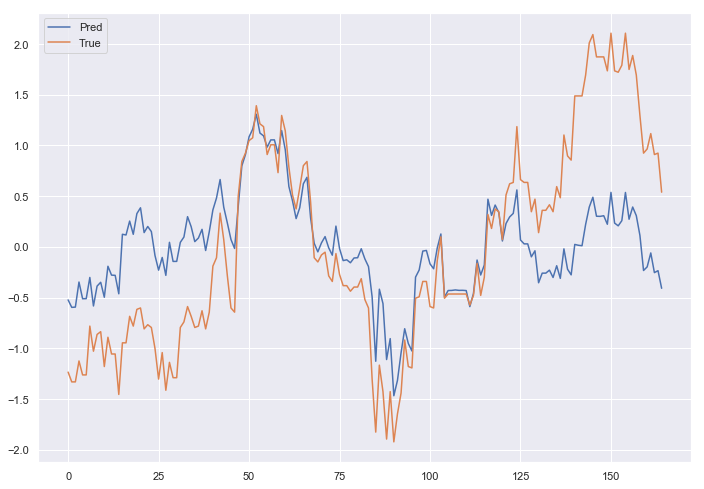

In [19]:
plt.plot(y_pred_best, label='Pred')
plt.plot(y_test, label='True')
plt.legend()

## Without grid search 

In [20]:
# regressor = SVR(kernel='rbf', gamma='scale', epsilon=0.000001, C=.3)
regressor = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
   kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
# regressor = SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=1.0, gamma='scale',
#   kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
regressor.fit(X_train,y_train.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [21]:
# y_pred = scaler_y_test.inverse_transform(regressor.predict(X_test))
# y_pred = scaler_y_train.inverse_transform(regressor.predict(X_test))
# y_test = scaler_y_test.inverse_transform(y_test)

In [22]:
y_pred = regressor.predict(X_test)

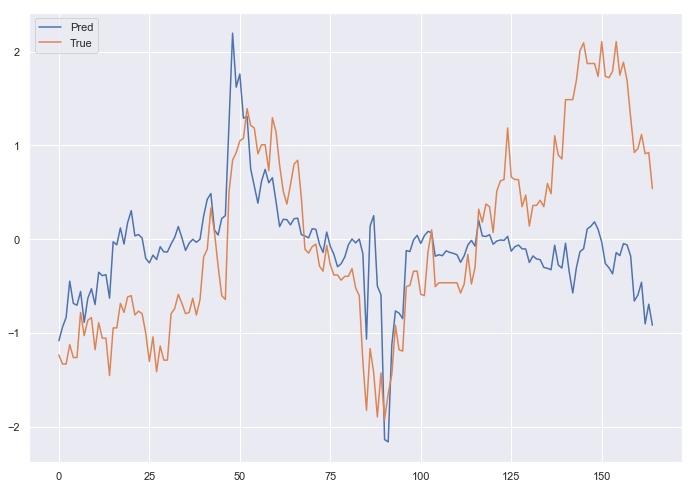

In [23]:
plt.plot(y_pred, label='Pred')
plt.plot(y_test, label='True')
plt.legend()

In [24]:
rms = sqrt(mean_squared_error(y_test, y_pred))
rms, np.mean(y_test), np.mean(y_pred)

(0.9294761798813543, -6.935813e-08, -0.09185056512039468)